In [1]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

Using TensorFlow backend.


In [3]:
df = pd.read_csv('^NSEI_withoutnull.csv')
df.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Open,High,Low,Close,Future_Close
0,2007-11-22,5564.649902,5608.649902,5394.350098,5519.350098,5608.600098
1,2007-11-23,5524.299805,5638.600098,5514.750000,5608.600098,5731.700195
2,2007-11-26,5611.299805,5772.549805,5608.950195,5731.700195,5698.149902
3,2007-11-27,5729.250000,5743.549805,5655.600098,5698.149902,5617.549805
4,2007-11-28,5699.549805,5749.950195,5595.500000,5617.549805,5634.600098


In [4]:
df.shape

(1048527, 6)

In [14]:
df = df.dropna(axis=0, how='any')

In [15]:
df = df.drop(['Date'], axis=1)
df.head()

ValueError: labels ['Date'] not contained in axis

In [16]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [17]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [38]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [39]:
df = df.astype(float)

In [40]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2157, 20, 5)
y_train (2157,)
X_test (240, 20, 5)
y_test (240,)


In [41]:
model = build_model([X_train.shape[2], window, 100, 1])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 5), units=20, return_sequences=True)`
  


Compilation Time :  0.10633182525634766


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [43]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    nb_epoch=300,
    validation_split=0.2,
    verbose=2)

/usr/local/lib/python3.5/dist-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1725 samples, validate on 432 samples
Epoch 1/300
1s - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0.0578 - val_acc: 0.0000e+00
Epoch 2/300
1s - loss: 0.0087 - acc: 0.0000e+00 - val_loss: 0.0473 - val_acc: 0.0000e+00
Epoch 3/300
1s - loss: 0.0083 - acc: 0.0000e+00 - val_loss: 0.0327 - val_acc: 0.0000e+00
Epoch 4/300
1s - loss: 0.0094 - acc: 0.0000e+00 - val_loss: 0.0986 - val_acc: 0.0000e+00
Epoch 5/300
1s - loss: 0.0152 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 6/300
1s - loss: 0.0086 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 7/300
1s - loss: 0.0083 - acc: 0.0000e+00 - val_loss: 0.0220 - val_acc: 0.0000e+00
Epoch 8/300
1s - loss: 0.0102 - acc: 0.0000e+00 - val_loss: 0.0721 - val_acc: 0.0000e+00
Epoch 9/300
1s - loss: 0.0104 - acc: 0.0000e+00 - val_loss: 0.0312 - val_acc: 0.0000e+00
Epoch 10/300
1s - loss: 0.0097 - acc: 0.0000e+00 - val_loss: 0.0640 - val_acc: 0.0000e+00
Epoch 11/300
1s - loss: 0.0107 - acc: 0.0000e+00 - val_loss: 0

1s - loss: 0.0156 - acc: 0.0000e+00 - val_loss: 0.0758 - val_acc: 0.0000e+00
Epoch 93/300
1s - loss: 0.0088 - acc: 0.0000e+00 - val_loss: 0.0448 - val_acc: 0.0000e+00
Epoch 94/300
1s - loss: 0.0074 - acc: 0.0000e+00 - val_loss: 0.0482 - val_acc: 0.0000e+00
Epoch 95/300
1s - loss: 0.0071 - acc: 0.0000e+00 - val_loss: 0.0607 - val_acc: 0.0000e+00
Epoch 96/300
1s - loss: 0.0089 - acc: 0.0000e+00 - val_loss: 0.0247 - val_acc: 0.0000e+00
Epoch 97/300
1s - loss: 0.0166 - acc: 0.0000e+00 - val_loss: 0.0650 - val_acc: 0.0000e+00
Epoch 98/300
1s - loss: 0.0079 - acc: 0.0000e+00 - val_loss: 0.0277 - val_acc: 0.0000e+00
Epoch 99/300
1s - loss: 0.0082 - acc: 0.0000e+00 - val_loss: 0.0505 - val_acc: 0.0000e+00
Epoch 100/300
1s - loss: 0.0079 - acc: 0.0000e+00 - val_loss: 0.0261 - val_acc: 0.0000e+00
Epoch 101/300
1s - loss: 0.0090 - acc: 0.0000e+00 - val_loss: 0.0810 - val_acc: 0.0000e+00
Epoch 102/300
1s - loss: 0.0120 - acc: 0.0000e+00 - val_loss: 0.0268 - val_acc: 0.0000e+00
Epoch 103/300
1s - l

1s - loss: 0.0087 - acc: 0.0000e+00 - val_loss: 0.0219 - val_acc: 0.0000e+00
Epoch 184/300
1s - loss: 0.0127 - acc: 0.0000e+00 - val_loss: 0.0613 - val_acc: 0.0000e+00
Epoch 185/300
1s - loss: 0.0074 - acc: 0.0000e+00 - val_loss: 0.0286 - val_acc: 0.0000e+00
Epoch 186/300
1s - loss: 0.0070 - acc: 0.0000e+00 - val_loss: 0.0230 - val_acc: 0.0000e+00
Epoch 187/300
1s - loss: 0.0108 - acc: 0.0000e+00 - val_loss: 0.0777 - val_acc: 0.0000e+00
Epoch 188/300
1s - loss: 0.0085 - acc: 0.0000e+00 - val_loss: 0.0207 - val_acc: 0.0000e+00
Epoch 189/300
1s - loss: 0.0078 - acc: 0.0000e+00 - val_loss: 0.0579 - val_acc: 0.0000e+00
Epoch 190/300
1s - loss: 0.0080 - acc: 0.0000e+00 - val_loss: 0.0184 - val_acc: 0.0000e+00
Epoch 191/300
1s - loss: 0.0095 - acc: 0.0000e+00 - val_loss: 0.0444 - val_acc: 0.0000e+00
Epoch 192/300
1s - loss: 0.0092 - acc: 0.0000e+00 - val_loss: 0.0178 - val_acc: 0.0000e+00
Epoch 193/300
1s - loss: 0.0093 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 194/300

1s - loss: 0.0081 - acc: 0.0000e+00 - val_loss: 0.0300 - val_acc: 0.0000e+00
Epoch 275/300
1s - loss: 0.0073 - acc: 0.0000e+00 - val_loss: 0.0885 - val_acc: 0.0000e+00
Epoch 276/300
1s - loss: 0.0084 - acc: 0.0000e+00 - val_loss: 0.0397 - val_acc: 0.0000e+00
Epoch 277/300
1s - loss: 0.0084 - acc: 0.0000e+00 - val_loss: 0.0633 - val_acc: 0.0000e+00
Epoch 278/300
1s - loss: 0.0081 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 279/300
1s - loss: 0.0068 - acc: 0.0000e+00 - val_loss: 0.0720 - val_acc: 0.0000e+00
Epoch 280/300
1s - loss: 0.0064 - acc: 0.0000e+00 - val_loss: 0.0273 - val_acc: 0.0000e+00
Epoch 281/300
1s - loss: 0.0094 - acc: 0.0000e+00 - val_loss: 0.0841 - val_acc: 0.0000e+00
Epoch 282/300
1s - loss: 0.0073 - acc: 0.0000e+00 - val_loss: 0.0372 - val_acc: 0.0000e+00
Epoch 283/300
1s - loss: 0.0086 - acc: 0.0000e+00 - val_loss: 0.0796 - val_acc: 0.0000e+00
Epoch 284/300
1s - loss: 0.0082 - acc: 0.0000e+00 - val_loss: 0.0369 - val_acc: 0.0000e+00
Epoch 285/300

In [45]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.09 RMSE)
Test Score: 0.01 MSE (0.11 RMSE)


In [46]:
diff = []
ratio = []
pred = model.predict(X_train)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

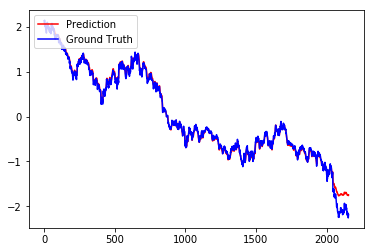

In [47]:
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_train, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()
%matplotlib inline

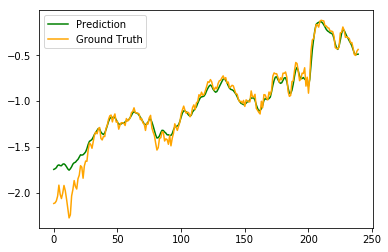

In [48]:
pred2 = model.predict(X_test)
plt2.plot(pred2, color='green', label='Prediction')
plt2.plot(y_test, color='orange', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()